## Is it a bird?

In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception

## Step 1: Download images of stones and stone monuments

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a photo of a stone and seeing what kind of result we get. We'll start by getting URLs from a search:

In [4]:
urls = search_images('stone photos', max_images=1)
urls[0]

Searching for 'stone photos'


'https://jooinn.com/images/stone-25.jpg'

...and then download a URL and take a look at it:

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


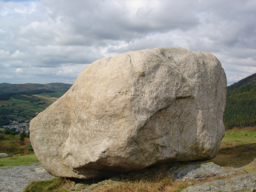

In [5]:
from fastdownload import download_url
dest = 'stone.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "stone monument photos":

In [ ]:
download_url(search_images('stone monument photos', max_images=1)[0], 'stone_monument.jpg', show_progress=False)
Image.open('stone_monument.jpg').to_thumb(256,256)